<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch13_data_loading_preprocessing_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 13 — Loading and Preprocessing Data with TensorFlow

## 1) Summary
In this chapter, I focus on **how to feed data into TensorFlow models correctly and efficiently**, and how to build **reproducible preprocessing pipelines** that can run the same way during training and inference.

What I implement and explain in this notebook:
- Building input pipelines with **`tf.data`** from NumPy / Pandas-like arrays.
- Key `tf.data` operations: `shuffle`, `batch`, `map`, `prefetch`, `cache`, `repeat`, `interleave`.
- Creating and using **TFRecords**:
  - writing `tf.train.Example` records,
  - reading with `TFRecordDataset`,
  - parsing with `tf.io.parse_single_example`.
- Using **Keras preprocessing layers** to keep preprocessing inside the model:
  - `Normalization`,
  - categorical encoders (`StringLookup`, `IntegerLookup`, `CategoryEncoding`),
  - simple mixed (numeric + categorical) inputs.
- Building a small end-to-end model that consumes a `tf.data.Dataset` pipeline.

My main outcome:
I end up with a clean pipeline: **raw data → tf.data → (optional TFRecords) → preprocessing layers → model**,
so the notebook is runnable, the pipeline is scalable, and the preprocessing logic stays consistent.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))

TensorFlow: 2.19.0
GPU available: True


## 2) Dataset Setup (California Housing)
I use California Housing for a structured example that is quick to run.

Why this dataset works well here:
- Tabular numeric features (easy to show scaling/normalization).
- Regression target (simple loss: MSE).
- It supports demonstrating:
  - `tf.data` from NumPy arrays,
  - TFRecord writing/reading,
  - preprocessing layers and end-to-end models.

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()

df.head(), df.shape

(   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
 0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
 1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
 2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
 3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
 4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
 
    Longitude  MedHouseVal  
 0    -122.23        4.526  
 1    -122.22        3.585  
 2    -122.24        3.521  
 3    -122.25        3.413  
 4    -122.25        3.422  ,
 (20640, 9))

In [3]:
# Separate features and target
target_col = "MedHouseVal"
X = df.drop(columns=[target_col])
y = df[target_col].astype(np.float32).to_numpy()

# Basic train/valid/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape, X_test.shape

((13209, 8), (3303, 8), (4128, 8))

## 3) Baseline tf.data pipeline (from NumPy / DataFrame)

### 3.1 Why tf.data?
`tf.data` is TensorFlow’s input pipeline API. It helps with:
- streaming data efficiently,
- shuffling/batching,
- parallel preprocessing with `map(num_parallel_calls=...)`,
- performance optimizations (`prefetch`, `cache`),
- integration with `.fit()`.

In practice, the most common pattern is:
`Dataset.from_tensor_slices(...) → shuffle → batch → map(preprocess) → prefetch`

In [4]:
# Convert DataFrame -> NumPy (float32)
X_train_np = X_train.to_numpy().astype(np.float32)
X_valid_np = X_valid.to_numpy().astype(np.float32)
X_test_np  = X_test.to_numpy().astype(np.float32)

feature_names = list(X_train.columns)
n_features = X_train_np.shape[1]
feature_names, n_features

(['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 8)

In [5]:
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train_np, y_train))
train_ds = train_ds.shuffle(buffer_size=len(X_train_np), seed=42).batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((X_valid_np, y_valid)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_np, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# sanity check
for X_batch, y_batch in train_ds.take(1):
    print(X_batch.shape, y_batch.shape)

(64, 8) (64,)


## 4) A small regression model using tf.data (baseline)

Before adding TFRecords and preprocessing layers, I train a baseline model to validate the pipeline works end-to-end.
This helps me catch issues early (shape mismatches, dtype issues, etc.).

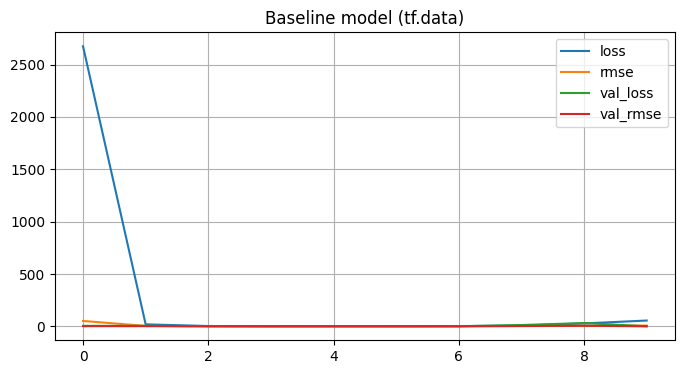

[0.8778418302536011, 0.9369320869445801]

In [6]:
baseline_model = keras.models.Sequential([
    keras.layers.Input(shape=(n_features,)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)
])

baseline_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

hist = baseline_model.fit(train_ds, validation_data=valid_ds, epochs=10, verbose=0)
pd.DataFrame(hist.history).plot(figsize=(8, 4), grid=True, title="Baseline model (tf.data)")
plt.show()

test_metrics = baseline_model.evaluate(test_ds, verbose=0)
test_metrics

# Part A — Performance-minded tf.data patterns

## 5) Pipeline building blocks I use most often

### 5.1 map()
`map()` applies a transformation per element (or per batch). Typical uses:
- feature engineering,
- parsing TFRecords,
- normalization / encoding (if not done inside the model).

### 5.2 cache()
`cache()` keeps data in memory (or local file) after first pass.
Good when data fits memory and preprocessing is expensive.

### 5.3 prefetch()
`prefetch()` overlaps preprocessing and model execution. This is almost always beneficial.

### 5.4 interleave()
Useful when reading many files (TFRecord shards). It overlaps file reads.

In this notebook, I keep most transforms simple but still use `prefetch(AUTOTUNE)` as a default.

# Part B — TFRecords

## 6) Why TFRecords?
TFRecords are a binary format optimized for TensorFlow pipelines:
- efficient sequential reads,
- works well with `tf.data.TFRecordDataset`,
- commonly used in production and at scale,
- allows sharding into many files for parallel reads.

Workflow:
1. Convert rows into `tf.train.Example`
2. Write them to a `.tfrecord` file
3. Read with `TFRecordDataset`
4. Parse back into tensors

In [7]:
# Helper functions to build tf.train.Example
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[float(value)]))

def _bytes_feature(value):
    if isinstance(value, str):
        value = value.encode("utf-8")
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(features, target):
    feature_dict = {name: _float_feature(features[i]) for i, name in enumerate(feature_names)}
    feature_dict["target"] = _float_feature(target)
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return example_proto.SerializeToString()

## 7) Write TFRecords (train/valid/test)

To keep the notebook self-contained, I write TFRecords locally in the runtime storage.
In Colab, these files will exist in the current session filesystem.

In [8]:
tfrecord_dir = "tfrecord_data"
os.makedirs(tfrecord_dir, exist_ok=True)

train_path = os.path.join(tfrecord_dir, "housing_train.tfrecord")
valid_path = os.path.join(tfrecord_dir, "housing_valid.tfrecord")
test_path  = os.path.join(tfrecord_dir, "housing_test.tfrecord")

def write_tfrecord(path, X_np, y_np):
    with tf.io.TFRecordWriter(path) as writer:
        for i in range(len(X_np)):
            writer.write(serialize_example(X_np[i], y_np[i]))

write_tfrecord(train_path, X_train_np, y_train)
write_tfrecord(valid_path, X_valid_np, y_valid)
write_tfrecord(test_path,  X_test_np,  y_test)

train_path, valid_path, test_path

('tfrecord_data/housing_train.tfrecord',
 'tfrecord_data/housing_valid.tfrecord',
 'tfrecord_data/housing_test.tfrecord')

## 8) Read + Parse TFRecords

### 8.1 Parsing schema
When parsing `tf.train.Example`, I must define a feature spec:
- numeric features: `FixedLenFeature([], tf.float32)`
- target: also a float feature

Then I convert the dictionary into a feature vector (tensor).

In [9]:
feature_spec = {name: tf.io.FixedLenFeature([], tf.float32) for name in feature_names}
feature_spec["target"] = tf.io.FixedLenFeature([], tf.float32)

def parse_tfrecord(serialized_example):
    parsed = tf.io.parse_single_example(serialized_example, feature_spec)
    y = parsed.pop("target")
    # Keep feature order stable
    X = tf.stack([parsed[name] for name in feature_names], axis=0)
    return X, y

raw_train_ds = tf.data.TFRecordDataset(train_path)
for raw in raw_train_ds.take(1):
    X_ex, y_ex = parse_tfrecord(raw)
    print(X_ex.shape, y_ex)

(8,) tf.Tensor(1.769, shape=(), dtype=float32)


## 9) Build tf.data pipeline from TFRecords
I rebuild train/valid/test datasets using TFRecords:
- shuffle (train only)
- map(parse)
- batch
- prefetch

In [10]:
tfrecord_train_ds = tf.data.TFRecordDataset(train_path)
tfrecord_train_ds = (tfrecord_train_ds
                     .shuffle(20000, seed=42)
                     .map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.AUTOTUNE))

tfrecord_valid_ds = (tf.data.TFRecordDataset(valid_path)
                     .map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.AUTOTUNE))

tfrecord_test_ds = (tf.data.TFRecordDataset(test_path)
                    .map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
                    .batch(batch_size)
                    .prefetch(tf.data.AUTOTUNE))

for Xb, yb in tfrecord_train_ds.take(1):
    print(Xb.shape, yb.shape)

(64, 8) (64,)


## 10) Train the same model on TFRecord pipeline
This verifies my TFRecord pipeline is functionally equivalent to the earlier in-memory pipeline.

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


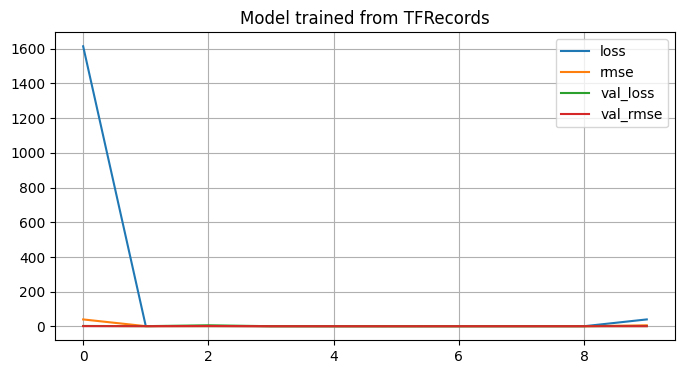

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[1.7029995918273926, 1.304990291595459]

In [11]:
tfrecord_model = keras.models.Sequential([
    keras.layers.Input(shape=(n_features,)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)
])

tfrecord_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

tfrecord_hist = tfrecord_model.fit(tfrecord_train_ds, validation_data=tfrecord_valid_ds, epochs=10, verbose=0)
pd.DataFrame(tfrecord_hist.history).plot(figsize=(8, 4), grid=True, title="Model trained from TFRecords")
plt.show()

tfrecord_model.evaluate(tfrecord_test_ds, verbose=0)

# Part C — Preprocessing inside the model (Keras preprocessing layers)

## 11) Why put preprocessing inside the model?
In many projects, preprocessing is a source of bugs:
- training uses preprocessing A
- inference uses preprocessing B
- small mismatches cause performance drops and deployment issues

Keras preprocessing layers help because:
- they are saved with the model,
- the same transformations run at training and inference,
- the pipeline becomes more portable.

Here I demonstrate:
- `Normalization` for numeric features
- a toy categorical feature with `StringLookup` + `CategoryEncoding`

## 12) Normalization layer (numeric features)

Steps:
1. Create `Normalization()`
2. `adapt()` it on training data
3. Use it as the first layer in the model

In [12]:
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train_np)  # adapt on raw training features

# sanity check: normalized mean ~0, std ~1 (not exact due to finite data)
X_norm_sample = normalizer(X_train_np[:1000]).numpy()
X_norm_sample.mean(axis=0)[:3], X_norm_sample.std(axis=0)[:3]

(array([ 0.01317783, -0.0218655 ,  0.05630967], dtype=float32),
 array([1.0489677 , 0.97734934, 1.2513257 ], dtype=float32))

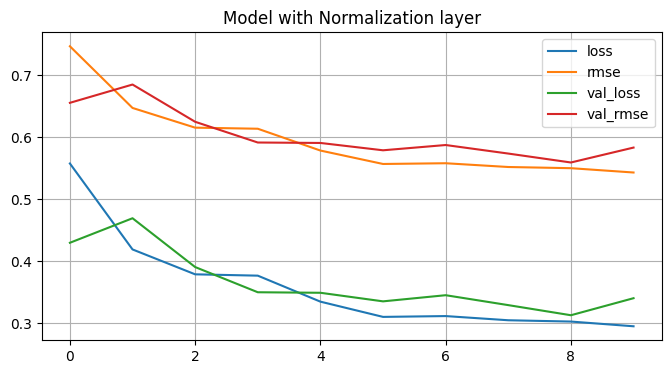

[0.3143453299999237, 0.5606650710105896]

In [13]:
norm_model = keras.models.Sequential([
    keras.layers.Input(shape=(n_features,)),
    normalizer,
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)
])

norm_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

norm_hist = norm_model.fit(train_ds, validation_data=valid_ds, epochs=10, verbose=0)
pd.DataFrame(norm_hist.history).plot(figsize=(8, 4), grid=True, title="Model with Normalization layer")
plt.show()

norm_model.evaluate(test_ds, verbose=0)

## 13) Mixed inputs: numeric + categorical (toy example)

California Housing is numeric-only, so I create a small toy categorical feature
to practice the encoding pipeline that I would use in real tabular datasets:
- `StringLookup` to map strings to integer IDs
- `CategoryEncoding` to one-hot encode IDs
- concatenate with normalized numeric features

This is a pattern I can reuse for real datasets with categorical columns.

In [14]:
# Create a toy categorical feature by binning median income into labels (for demonstration)
income = df["MedInc"].to_numpy()
bins = np.quantile(income, [0.2, 0.4, 0.6, 0.8])
def income_bucket(x):
    if x <= bins[0]: return "very_low"
    if x <= bins[1]: return "low"
    if x <= bins[2]: return "mid"
    if x <= bins[3]: return "high"
    return "very_high"

cat_all = np.array([income_bucket(v) for v in income], dtype=object)

# Split the categorical feature using the same indices
cat_train_full, cat_test = train_test_split(cat_all, test_size=0.2, random_state=42, stratify=None)
cat_train, cat_valid = train_test_split(cat_train_full, test_size=0.2, random_state=42, stratify=None)

# Align numeric splits (we already split X/y earlier, so rebuild category splits using indices for correctness)
# To keep it simple and reproducible, rebuild from the earlier DataFrame splits:
cat_train = np.array([income_bucket(v) for v in X_train_full["MedInc"].to_numpy()], dtype=object)
cat_test  = np.array([income_bucket(v) for v in X_test["MedInc"].to_numpy()], dtype=object)

# Then split cat_train_full to cat_train/cat_valid in the same sizes as earlier
cat_valid, cat_train = cat_train[:len(X_valid_np)], cat_train[len(X_valid_np):]

cat_train.shape, cat_valid.shape, cat_test.shape

((13209,), (3303,), (4128,))

In [15]:
# Build tf.data with (numeric_features, categorical_string) -> target
train_mixed_ds = tf.data.Dataset.from_tensor_slices(((X_train_np, cat_train), y_train))
train_mixed_ds = train_mixed_ds.shuffle(len(X_train_np), seed=42).batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_mixed_ds = tf.data.Dataset.from_tensor_slices(((X_valid_np, cat_valid), y_valid)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_mixed_ds  = tf.data.Dataset.from_tensor_slices(((X_test_np,  cat_test),  y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

for (Xb, cb), yb in train_mixed_ds.take(1):
    print(Xb.shape, cb.shape, yb.shape, cb[:5].numpy())

(64, 8) (64,) (64,) [b'very_high' b'low' b'mid' b'very_high' b'mid']


In [16]:
# Preprocessing for categorical feature
cat_lookup = keras.layers.StringLookup(output_mode="int")
cat_lookup.adapt(cat_train)  # adapt on training categories

cat_onehot = keras.layers.CategoryEncoding(num_tokens=cat_lookup.vocabulary_size(), output_mode="one_hot")

# Inputs
num_input = keras.layers.Input(shape=(n_features,), name="numeric")
cat_input = keras.layers.Input(shape=(), dtype=tf.string, name="income_bucket")

# Numeric preprocessing
num_norm = keras.layers.Normalization(axis=-1)
num_norm.adapt(X_train_np)
num_encoded = num_norm(num_input)

# Categorical preprocessing
cat_ids = cat_lookup(cat_input)
cat_encoded = cat_onehot(cat_ids)

# Combine
all_features = keras.layers.Concatenate()([num_encoded, cat_encoded])

x = keras.layers.Dense(64, activation="relu")(all_features)
x = keras.layers.Dense(64, activation="relu")(x)
output = keras.layers.Dense(1)(x)

mixed_model = keras.Model(inputs=[num_input, cat_input], outputs=output)
mixed_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ income_bucket       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric             │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup       │ (None)            │          0 │ income_bucket[0]… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 8)         │         17 │ numeric[0][0]     │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding   │ (None, 6)         │          0 │ string_lookup[0]… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14)        │          0 │ normalization_1[… │
│ (Concatenate)       │                   │            │ category_encodin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │        960 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,202 (20.32 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 17 (72.00 B)

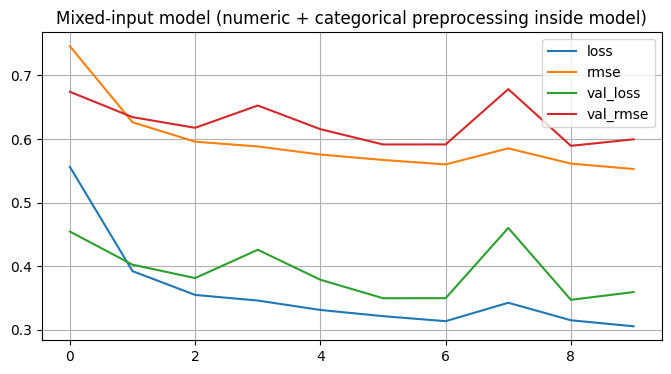

[0.3196905553340912, 0.5654118657112122]

In [17]:
mixed_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

mixed_hist = mixed_model.fit(train_mixed_ds, validation_data=valid_mixed_ds, epochs=10, verbose=0)
pd.DataFrame(mixed_hist.history).plot(figsize=(8, 4), grid=True, title="Mixed-input model (numeric + categorical preprocessing inside model)")
plt.show()

mixed_model.evaluate(test_mixed_ds, verbose=0)

# Part D — End-to-end saving (preprocessing included)

## 14) Save and reload the mixed model
Because preprocessing layers are inside the model, saving the model also saves:
- vocabulary for `StringLookup`
- normalization statistics for `Normalization`

This is the exact behavior I want when I move from training → inference.

In [18]:
save_path = "ch13_mixed_preprocessing_model.keras"
mixed_model.save(save_path)

reloaded = keras.models.load_model(save_path)
reloaded.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ income_bucket       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric             │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup       │ (None)            │          0 │ income_bucket[0]… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 8)         │         17 │ numeric[0][0]     │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding   │ (None, 6)         │          0 │ string_lookup[0]… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14)        │          0 │ normalization_1[… │
│ (Concatenate)       │                   │            │ category_encodin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │        960 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,574 (60.84 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 17 (72.00 B)

 Optimizer params: 10,372 (40.52 KB)

In [21]:
# Quick prediction sanity check
sample_num = X_test_np[:3].astype(np.float32)
sample_cat = tf.constant(cat_test[:3].astype(str), dtype=tf.string)

preds = reloaded.predict({"numeric": sample_num, "income_bucket": sample_cat}, verbose=0)
preds


array([[0.54607  ],
       [1.2848969],
       [5.0889277]], dtype=float32)

## 15) Takeaways
- `tf.data` is the standard way to build scalable, performant TensorFlow input pipelines.
- The most common pattern I use: `shuffle → batch → map → prefetch` (plus `cache` when appropriate).
- TFRecords are useful when data is large, distributed, or needs efficient sequential reads.
- Parsing TFRecords requires a clear schema (`FixedLenFeature`, `VarLenFeature`, etc.).
- Keras preprocessing layers help avoid train/inference mismatch by embedding preprocessing in the model.
- For tabular data, the pattern “Normalization + (Lookup → OneHot/Embedding) + Concatenate” is reusable and production-friendly.

## 16) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 13.
- TensorFlow documentation: `tf.data`, TFRecords, `tf.train.Example`.
- Keras preprocessing layers: `Normalization`, `StringLookup`, `CategoryEncoding`.